**Sentiment analaysis**

In [3]:
# Dataset

from google.colab import drive
import pandas as pd
import numpy as np

drive.mount("/content/drive")

y_names = ["negative", "positive"]

# Sentiment Labelled Sentences Data Set from the UCI (University of California Irvine) Machine Learning Repository
# https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
dataset = pd.read_csv("/content/drive/My Drive/data/sentiment labelled sentences/yelp_labelled.txt", sep="\t", names=y_names)

y = np.array(dataset.get(y_names[1]).tolist())
raw_dataset = dataset.get(y_names[0]).tolist()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Text preprocessing

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

dataset = []
stemmer = SnowballStemmer("english")
stopwords_en = stopwords.words("english")

for i in range(0, len(raw_dataset)):  
  tokens = regexp_tokenize(str(raw_dataset[i]), r"\w+")
  stems = [stemmer.stem(token) for token in tokens]
  words_no_stopwords = [word for word in stems if word not in stopwords_en]
  document = ' '.join(words_no_stopwords)
  dataset.append(document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Feature extraction (converting text to vectors)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset).toarray()

In [6]:
# Split training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# Define the keras model

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [8]:
# Compile the keras model and fit the model on the dataset

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, verbose=False, validation_data=(X_test, y_test), batch_size=10)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                15760     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 15,857
Trainable params: 15,857
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Evaluate model

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9975
Testing Accuracy:  0.7600


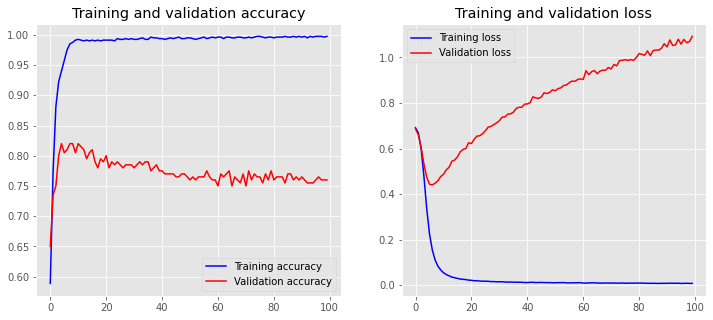

In [10]:
# Plot loss and accuracy for the training and testing data 

import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(0, len(acc))
  
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training accuracy')
  plt.plot(x, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

plot_history(history)

In [16]:
# Predict unseen data
unseen_sentence = input("Enter a sentence: ")
X_unseen = vectorizer.transform([unseen_sentence]).toarray()

y_unseen = np.argmax(model.predict(X_unseen), axis=-1) # Equivalent to: y_unseen = model.predict_classes(X_unseen)
print("The pedicted class for that sentence is:", y_names[y_unseen[0]])

Enter a sentence: This is very bad
The pedicted class for that sentence is: negative


In [17]:
# Savel model

import h5py

model_structure = model.to_json()

with open("sentiment_analysis_model.json", "w") as json_file:
  json_file.write(model_structure)

model.save_weights("sentiment_analysis_weights.h5")